In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [2]:
# Geographic and population centers for each county in US.
county_centers = pd.read_csv(f"{homedir}/data/us/geolocation/county_centers.csv")

In [3]:
county_centers.head()

,fips,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10
0,1001,-86.577176,32.523283,-86.644490,32.536382,-86.501832,32.500323,-86.494165,32.500389
1,1003,-87.748260,30.592781,-87.746067,30.659218,-87.760540,30.565383,-87.762381,30.548923
2,1005,-85.331312,31.856515,-85.405456,31.870670,-85.306746,31.847869,-85.310038,31.844036
3,1007,-87.123243,33.040054,-87.127148,33.015893,-87.127019,33.025947,-87.127659,33.030921
4,1009,-86.554768,33.978461,-86.567246,33.977448,-86.582617,33.962601,-86.591491,33.955243


In [4]:
# Confirmed Cases 
confirmed_cases = pd.read_csv(f"{homedir}/data/us/covid/confirmed_cases.csv")

In [5]:
confirmed_cases[confirmed_cases["State"] == "CA"].sample(5)

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
141,6099,Stanislaus County,CA,6,0,0,0,0,0,0,...,3,4,5,5,5,5,8,10,11,12
128,6071,San Bernardino County,CA,6,0,0,0,0,0,0,...,2,2,5,5,9,10,17,17,38,54
105,6007,Butte County,CA,6,0,0,0,0,0,0,...,0,0,0,0,0,1,2,3,4,4
146,6115,Yuba County,CA,6,0,0,0,0,0,0,...,0,0,0,0,0,2,2,2,3,5
110,6023,Humboldt County,CA,6,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,5,5


In [6]:
# Join County Centers Table with Confirmed Cases Table
# ft. CS 121
# - https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
combined = county_centers.rename(
    {'fips': 'countyFIPS'}, axis='columns'
    ).join(
        confirmed_cases.set_index('countyFIPS'), on='countyFIPS', how='inner'
    )

# Will also throw out Alaska and Hawaiians for viz reasons later (big L for Alaskans and Hawaiians, sorry)
# Use ~ for not or ! when using pandas Series or DataFrames
# Use pd.Series.isin() here to check membership because the resulting list shape remains the same
# Or else the two comparisons will return two different sized lists

combined = combined[~combined["State"].isin(["AK", "HI"])]

In [7]:
combined[combined["State"] == "CA"].sample(5).head()

,countyFIPS,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10,County Name,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
237,6097,-122.768624,38.440089,-122.945194,38.532574,-122.72102,38.412820,-122.720522,38.414080,Sonoma County,...,6,6,8,9,21,23,25,29,34,39
221,6065,-116.803605,33.783307,-116.002239,33.729828,-117.05238,33.811806,-117.066205,33.800439,Riverside County,...,15,16,16,22,28,30,45,47,59,107
218,6059,-117.861663,33.731518,-117.777207,33.675687,-117.86772,33.736492,-117.862880,33.733953,Orange County,...,22,29,42,53,65,78,95,125,152,187
230,6083,-120.071425,34.649384,-120.038485,34.537378,-120.07063,34.622048,-120.092602,34.639262,Santa Barbara County,...,1,1,3,8,9,13,18,18,24,26
232,6087,-121.973761,37.002349,-122.007205,37.012488,-121.93911,36.987764,-121.936728,36.985171,Santa Cruz County,...,9,13,13,14,15,15,15,22,24,25


In [8]:
# Load geographic county neighbors
# As edges of our graph
raw_neighbor_counties = pd.read_csv(f"{homedir}/data/us/geolocation/neighborcounties.csv")

# If an edge pair is not found (i.e. not corresponding county FIPS in original dataset)
# Then throw the edge out
full_fips_lst = combined["countyFIPS"].to_list()
full_fips = set(full_fips_lst)

# Use pd.Series.isin() here to check membership because the resulting list shape remains the same
# Or else the two comparisons will return two different sized lists
neighbor_counties = raw_neighbor_counties[raw_neighbor_counties["orgfips"].isin(full_fips) & 
                                          raw_neighbor_counties["adjfips"].isin(full_fips)]

In [9]:
neighbor_counties.head()

,orgfips,adjfips,instate
0,1001,1021,1
1,1001,1047,1
2,1001,1051,1
4,1001,1101,1
7,1003,1097,1


In [10]:
# Turn pandas dataframe table into list of tuples
# - https://stackoverflow.com/questions/36518027/pandas-creating-new-data-frame-from-only-certain-columns
# So we can pass into network x and build our graph
# - https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html

# NOTE: df[["col1", "col2"]] does not actually copy data itself, just creates a separate view (i.e. like reference)
county_edges = list(neighbor_counties[["orgfips","adjfips"]].to_records(index=False))
G = nx.Graph()

# Note: Try to add nodes in order first, for visualization purposes later
G.add_nodes_from(full_fips_lst)
G.add_edges_from(county_edges)

In [11]:
list(G.neighbors(1001))

[1021, 1047, 1051, 1101]

In [12]:
# Let's visualize! Need to specify latitude and longitude coordinates as distance metric
# need a dictionary with nodes as keys and positions as values
# - https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx

# NOTE: df[["col1", "col2"]] does not actually copy data itself, just creates a separate view (i.e. like reference)

nodes = combined["countyFIPS"].to_list()
locs = list(combined[["clon10", "clat10"]].to_numpy())

location_dictionary = dict(zip(nodes, locs))


In [13]:
location_dictionary

{1001: array([-86.64449 ,  32.536382]),
 1003: array([-87.746067,  30.659218]),
 1009: array([-86.567246,  33.977448]),
 1013: array([-86.681969,  31.751667]),
 1015: array([-85.822513,  33.771706]),
 1017: array([-85.391812,  32.917943]),
 1019: array([-85.654242,  34.069515]),
 1021: array([-86.726627,  32.854059]),
 1027: array([-85.862051,  33.267809]),
 1029: array([-85.516109,  33.671981]),
 1033: array([-87.801457,  34.703112]),
 1043: array([-86.869267,  34.131923]),
 1047: array([-87.114356,  32.33354 ]),
 1051: array([-86.142738,  32.597229]),
 1055: array([-86.03442 ,  34.047638]),
 1059: array([-87.842815,  34.441988]),
 1069: array([-85.296398,  31.158193]),
 1071: array([-85.9774  ,  34.763522]),
 1073: array([-86.896536,  33.553444]),
 1075: array([-88.087431,  33.787085]),
 1077: array([-87.650997,  34.904122]),
 1079: array([-87.321865,  34.529776]),
 1081: array([-85.353048,  32.604064]),
 1083: array([-86.981399,  34.810239]),
 1089: array([-86.55108 ,  34.764238]),


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


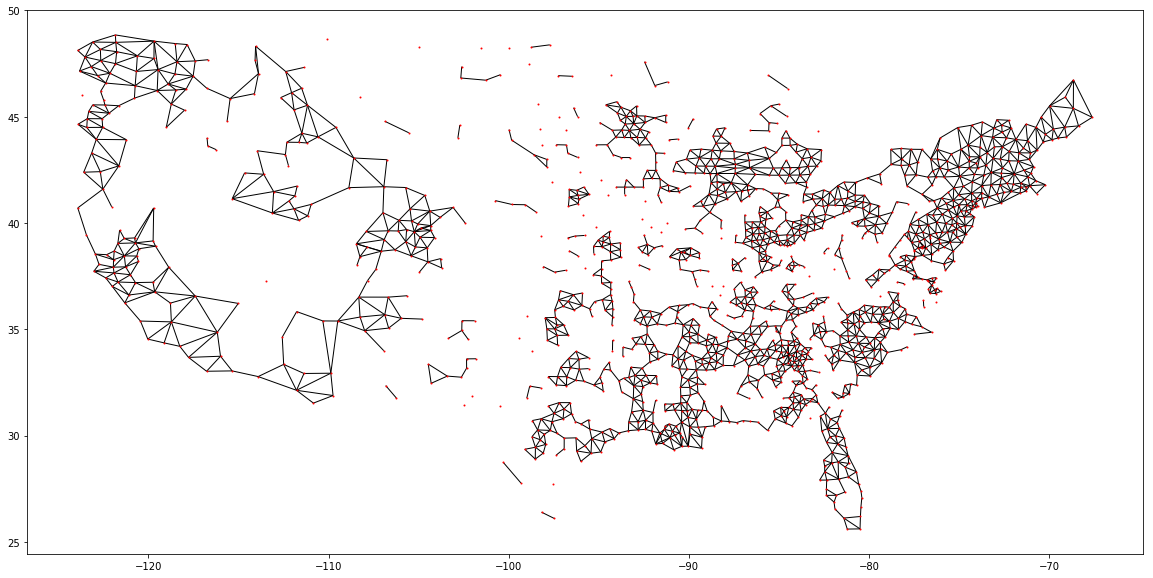

In [14]:
plt.figure(figsize=(20,10))
nx.drawing.nx_pylab.draw_networkx(
        G, 
        pos=location_dictionary,
        node_size=1,
        with_labels=False)
plt.show()

In [15]:
# Could also attributes to each node ID 
# - https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html#adding-attributes-to-graphs-nodes-and-edges

In [16]:
# Now let's provide a size metric for our nodes based on our data
# Use some arbitrary days in March and see how the virus spreads
march10_cases = combined["3/10/20"].to_list()

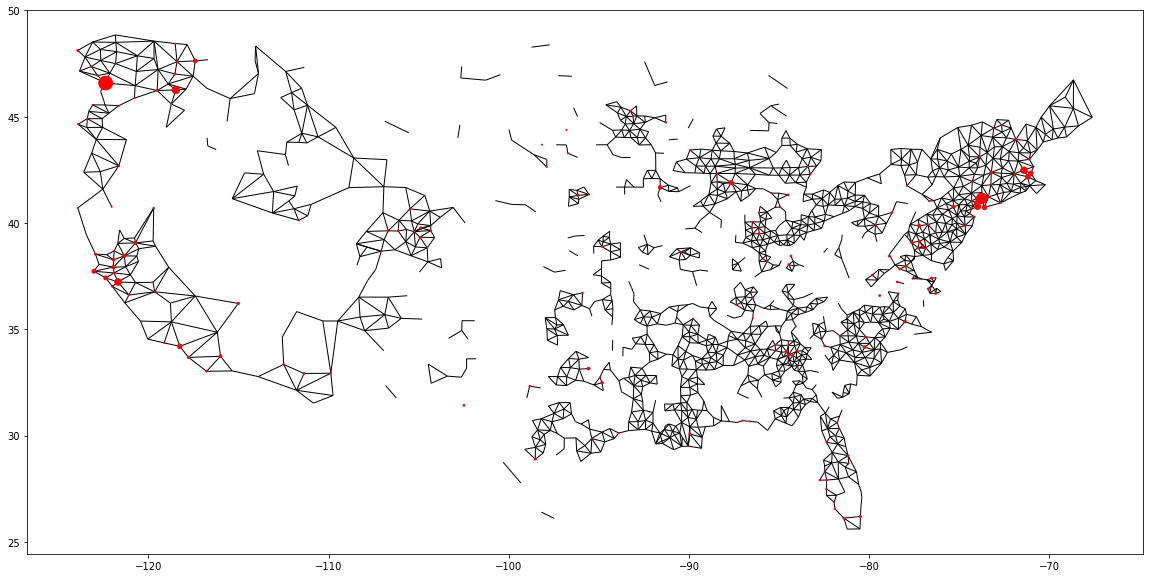

In [17]:
plt.figure(figsize=(20,10))
nx.drawing.nx_pylab.draw_networkx(
        G, 
        pos=location_dictionary,
        node_size=march10_cases,
        with_labels=False)
plt.show()

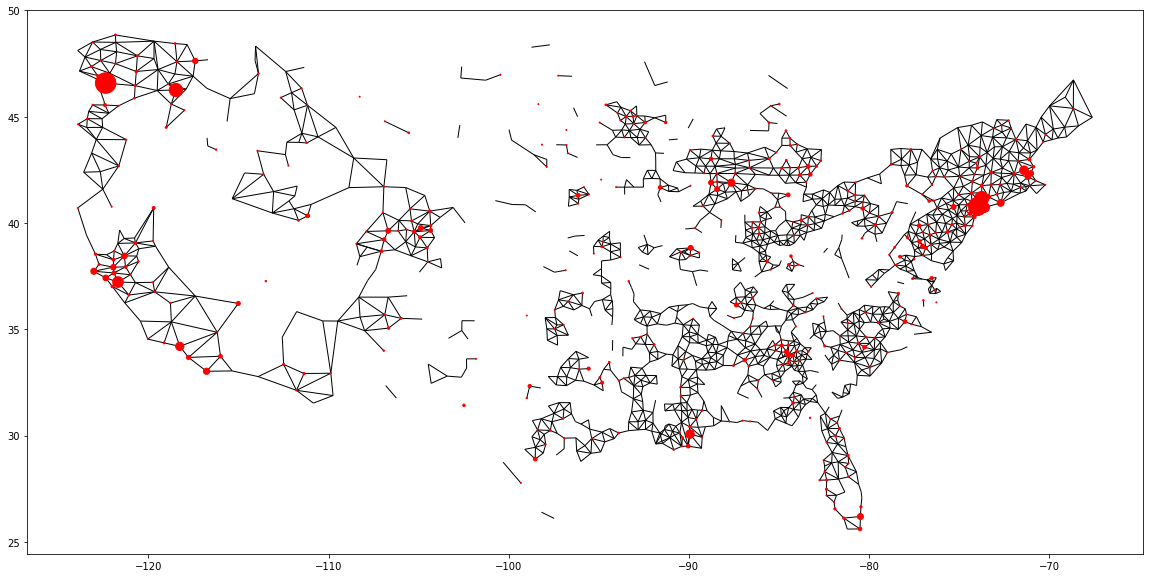

In [18]:
march15_cases = combined["3/15/20"].to_list()
plt.figure(figsize=(20,10))
nx.drawing.nx_pylab.draw_networkx(
        G, 
        pos=location_dictionary,
        node_size=march15_cases,
        with_labels=False)
plt.show()

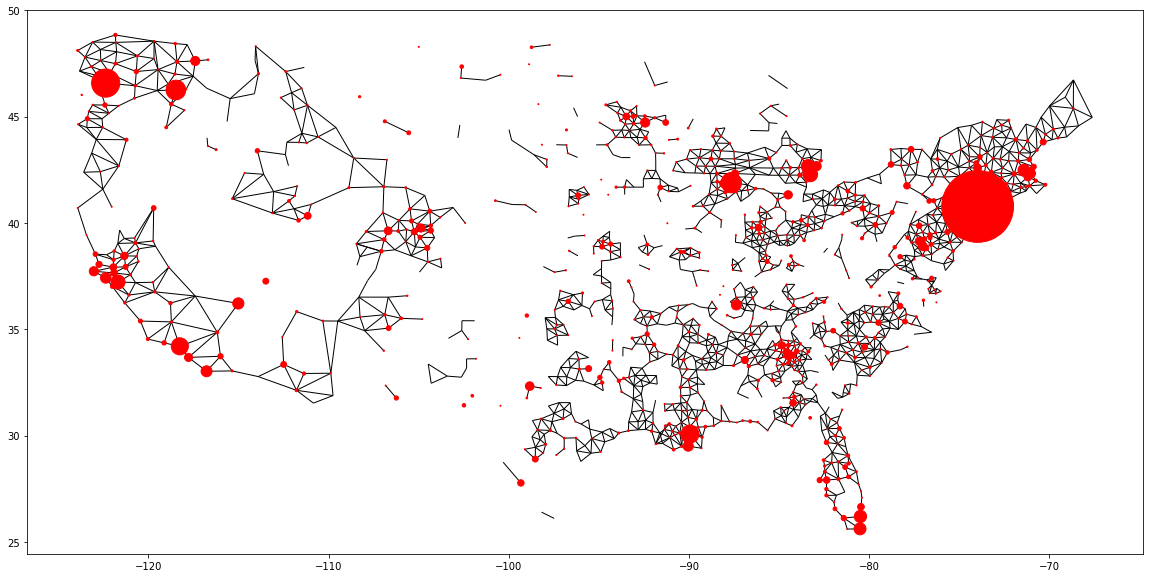

In [19]:
march20_cases = combined["3/20/20"].to_list()
plt.figure(figsize=(20,10))
nx.drawing.nx_pylab.draw_networkx(
        G, 
        pos=location_dictionary,
        node_size=march20_cases,
        with_labels=False)
plt.show()

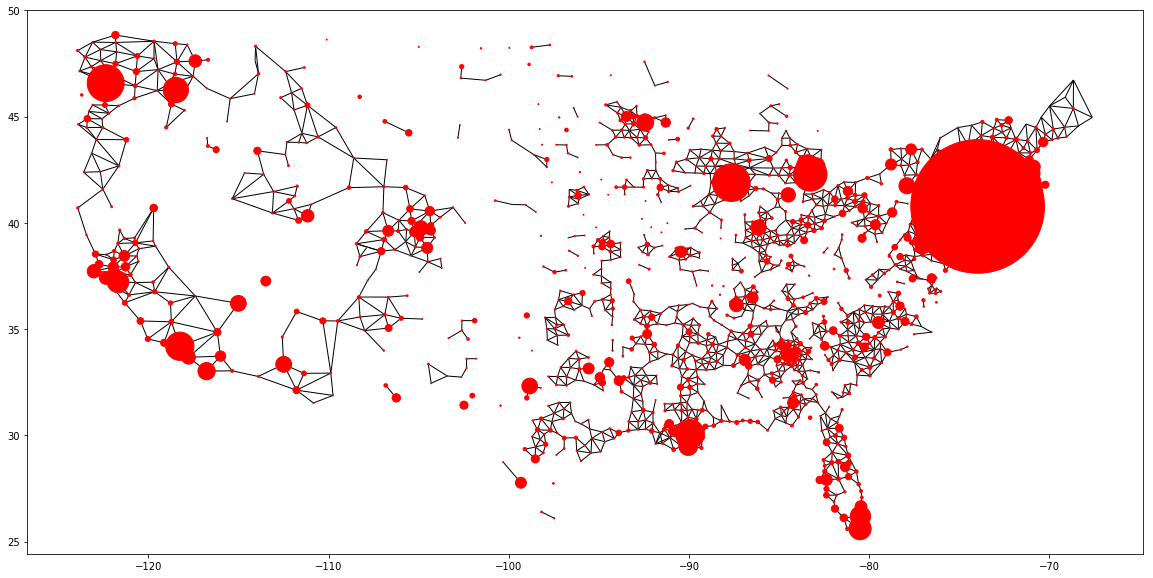

In [27]:
march25_cases = combined.sort_values("countyFIPS")["3/25/20"].to_list()
plt.figure(figsize=(20,10))
nx.drawing.nx_pylab.draw_networkx(
        G, 
        pos=location_dictionary,
        node_size=march25_cases,
        with_labels=False)
plt.show()

In [21]:
combined.sort_values(by=["3/25/20"], ascending=False).head()

,countyFIPS,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10,County Name,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
1861,36061,-73.973533,40.769656,-73.970174,40.776557,-73.964923,40.780432,-73.966303,40.777958,New York City,...,463,814,2009,3954,5151,8115,9654,12339,14776,17856
1890,36119,-73.794013,41.057167,-73.745912,41.152770,-73.805386,41.039278,-73.804532,41.040536,Westchester County,...,220,380,538,798,1091,1385,1873,2894,3891,4691
1860,36059,-73.602538,40.715949,-73.589384,40.729687,-73.601185,40.715749,-73.602242,40.716587,Nassau County,...,109,131,183,372,754,1234,1900,2442,2869,3285
1882,36103,-73.026232,40.833314,-72.692218,40.943554,-73.119032,40.820237,-73.113775,40.821924,Suffolk County,...,63,84,116,178,371,662,1034,1458,1880,2260
613,17031,-87.767817,41.837649,-87.645455,41.894294,-87.752517,41.864508,-87.757714,41.865937,Cook County,...,77,107,178,278,411,548,805,922,1194,1418
